# Hugging face

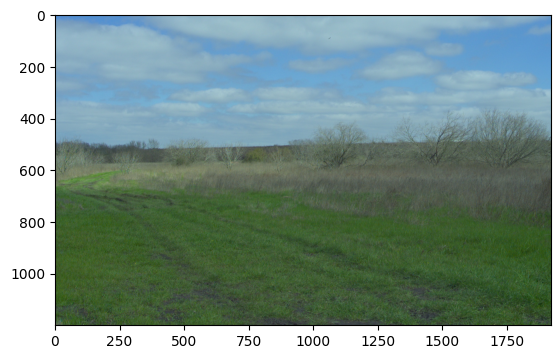

In [4]:
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, AutoModel

img = Image.open('/home/imlab/drivable_area_research/data/rellis/frame000000-1581623790_349.jpg')
img_np = np.array(img) ## 행렬로 변환된 이미지

plt.imshow(img_np) ## 행렬 이미지를 다시 이미지로 변경해 디스플레이
plt.show() ## 이미지 인터프린터에 출력

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-giant', crop_size={'height':644, 'width':644}, size={'height':644, 'width':644})
model = AutoModel.from_pretrained('facebook/dinov2-giant')

inputs = processor(images=img_np, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

output_size = int(inputs.pixel_values[0].shape[1]/14)

In [36]:
last_hidden_states.shape

torch.Size([1, 2117, 1536])

In [37]:
from numpy.linalg import norm

idx = 220
mean = last_hidden_states[0][idx].detach().numpy()

cosine_sim = np.dot(last_hidden_states[0].detach().numpy(), mean) / (norm(last_hidden_states[0].detach().numpy())*norm(mean))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.9254032].


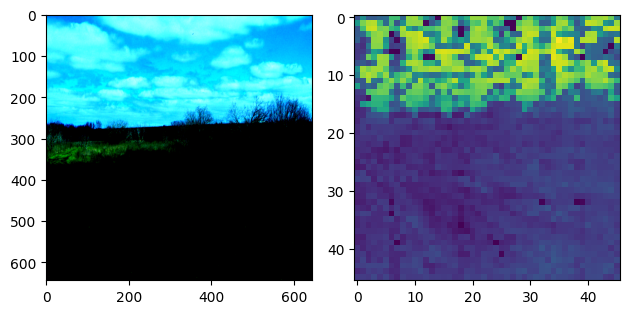

In [38]:
norm_cosine = cosine_sim/np.max(cosine_sim)

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.907974].


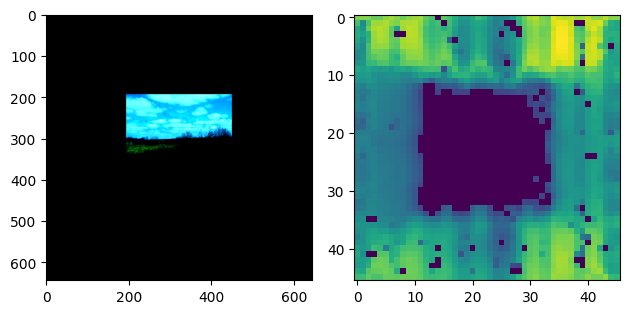

In [14]:
norm_cosine[np.where(norm_cosine<0.2)[0]] = 0

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

# Github

In [2]:
import torch
import os
import sys

os.environ["XFORMERS_DISABLED"] = "1" # Switch to enable xFormers

dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Using cache found in /home/imlab/.cache/torch/hub/facebookresearch_dinov2_main
/home/imlab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:45: UserWarning: xFormers is disabled (SwiGLU)
  warnings.warn("xFormers is disabled (SwiGLU)")
/home/imlab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/imlab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:29: UserWarning: xFormers is disabled (Attention)
  warnings.warn("xFormers is disabled (Attention)")
/home/imlab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/imlab/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:35: UserWarning: xFormers is disabled (Block)
  warnings.warn("xFormers is disable

In [16]:
from numpy.linalg import norm

idx = 1865
mean = dinov2_vitg14.get_intermediate_layers(inputs.pixel_values)[0][0][idx].detach().numpy()

cosine_sim = np.dot(last_hidden_states[0].detach().numpy(), mean) / (norm(last_hidden_states[0].detach().numpy())*norm(mean))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.9254032].


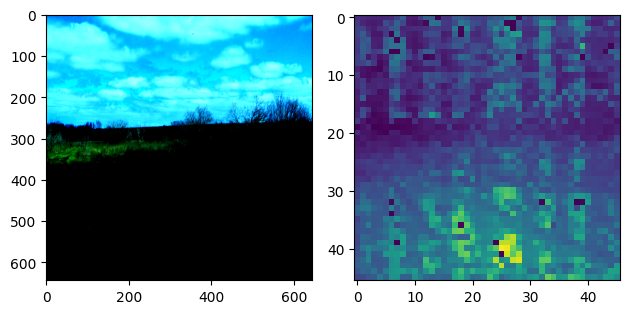

In [17]:
norm_cosine = cosine_sim/np.max(cosine_sim)

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1.9254032].


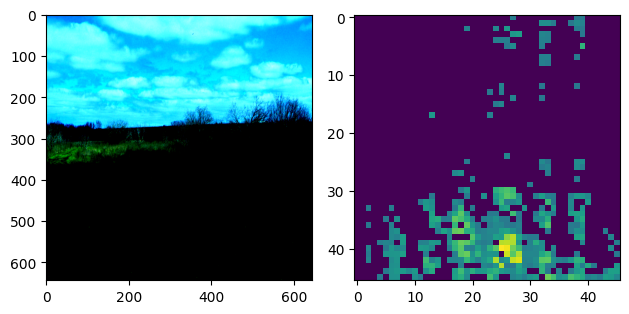

In [18]:
norm_cosine[np.where(norm_cosine<0.4)[0]] = 0

plt.subplot(1,2,1)
plt.imshow(inputs.pixel_values[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(norm_cosine[1:].reshape((output_size, output_size)))
# plt.colorbar()
plt.tight_layout()
plt.show()